# Run cells from AllenDB

In [ ]:
!pip install --upgrade numpy==1.24.4 pandas==2.2.2 scipy==1.11.3> /dev/null 2>&1

import os
os.kill(os.getpid(), 9)#restart so the above packages can be used

#after the above cell has restarted the session, run all below

#choose specimen id and model type

In [1]:
# Mouse L2/3 SST (Som) cell
# http://celltypes.brain-map.org/mouse/experiment/electrophysiology/476686112
specimen_id = 476686112
model_type = 'perisomatic'#or 'all active'
work_dir = 'OriginalFromAllenDB'

In [2]:
# If running in Colab
!pip install --upgrade pip2 > /dev/null 2>&1
!pip install --quiet allensdk neuron > /dev/null 2>&1
!git clone -b release_candidate https://github.com/V-Marco/ACT.git > /dev/null 2>&1

In [2]:
from allensdk.model.biophys_sim.config import Config
from allensdk.model.biophysical.utils import Utils
import os
import json
import matplotlib.pyplot as plt
import numpy as np
import sys
sys.path.append("ACT")
from act.passive import ACTPassiveModule

In [2]:
!pip install --quiet allensdk neuron

In [3]:
from allensdk.api.queries.biophysical_api import BiophysicalApi
from allensdk.model.biophys_sim.config import Config
from allensdk.model.biophysical.utils import Utils

#Download the cell -  if using HOC: upload the hoc template to the working directory and modfiles into a folder named 'modfiles' and skip to 'Build the Cell' then 'Simulation Parameters'

#Also if using hoc, double check parameters every time build_cell() is used

In [4]:
#get the model id

bp = BiophysicalApi()#using AllenDB's API
models = bp.get_neuronal_models(specimen_id)

for model in models:
  if model_type in model['name'].lower():
    print(f"model id = {model['id']}\n")
    model_id = model['id']
models

model id = 477878284



[{'id': 477878284,
  'name': 'Biophysical - perisomatic_Sst-IRES-Cre;Ai14-188740.03.02.01',
  'neuron_reconstruction_id': 491119369,
  'neuronal_model_template_id': 329230710,
  'specimen_id': 476686112},
 {'id': 497232660,
  'name': 'Biophysical - all active_Sst-IRES-Cre;Ai14-188740.03.02.01',
  'neuron_reconstruction_id': 491119369,
  'neuronal_model_template_id': 491455321,
  'specimen_id': 476686112}]

In [5]:
# Download the cell
bp.cache_stimulus = False # Change to False to not download the large stimulus NWB file
bp.cache_data(model_id, working_directory = work_dir )
os.chdir(work_dir)

2025-05-25 02:16:14,956 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/657210401
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/657210401
2025-05-25 02:16:15,933 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/657210404
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/657210404
2025-05-25 02:16:16,205 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/395337293
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/395337293
2025-05-25 02:16:16,491 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_fi

## Build the cell

add vecstim, cpampain.mod,NMDAIN.mod from https://github.com/yzerlaut/pv-sst-dendrites/tree/main/detailed_model and compile

if you need additonal modfiles from a public repo, provide a list of the names of the modfiles and a link to the folder

In [8]:
import requests
path = "https://raw.githubusercontent.com/yzerlaut/pv-sst-dendrites/main/detailed_model/mechanisms"
filenames = ['NMDAIN.mod','vecstim.mod','cpampain.mod', 'gabaain.mod']

for filename in filenames:

  url = os.path.join(path,filename)
  response = requests.get(url)

  if response.status_code == 200:
      with open(os.path.join('modfiles',filename), 'w') as f:#assuming you are in work_dir and the mechanisms are in a folder called 'modflies'
          f.write(response.text)
  else:
      print(f"Failed to download file: {response.status_code}")

In [6]:
# Compile the modfiles

!nrnivmodl modfiles > /dev/null 2>&1

In [7]:
import sys, os
from functools import wraps

def suppress_output(fn):
    @wraps(fn)
    def wrapper(*args, **kwargs):
        devnull = open(os.devnull, 'w')
        old_stdout, old_stderr = sys.stdout, sys.stderr
        sys.stdout = sys.stderr = devnull
        try:
            return fn(*args, **kwargs)
        finally:
            sys.stdout, sys.stderr = old_stdout, old_stderr
            devnull.close()
    return wrapper

**NOTE:** Control the soma area in the `build_cell` function below.

In [8]:
@suppress_output
def build_cell(soma_diam_multiplier = 1,using_hoc=False,hoc_filename=None,cell_name=None):

    if using_hoc:
      from neuron import h
      h.load_file(hoc_filename)
      return getattr(h, cell_name)()
    # Create the h object
    description = Config().load('manifest.json')
    utils = Utils(description)
    h = utils.h
    # Convert all "value" attributes to floats
    for dict in utils.description.data['genome']:
        for key, value in dict.items():
            if key == 'value': dict[key] = float(value)
    # Configure morphology
    morphology_path = description.manifest.get_path('MORPHOLOGY')
    utils.generate_morphology(morphology_path.encode('ascii', 'ignore'))
    utils.load_cell_parameters()
    # To match PP
    h.soma[0].diam = h.soma[0].diam * soma_diam_multiplier

    return h

def set_simulation(hoc_object,sim_params, soma_diam_multiplier = 1.0):
    from neuron import h
    h.load_file("stdrun.hoc")
    stim = h.IClamp(hoc_object.soma[0](0.5))
    stim.amp = sim_params['stim_amp']
    stim.delay = sim_params['stim_delay']
    stim.dur = sim_params['stim_dur']
    h.tstop = sim_params['h_tstop']
    h.dt = sim_params['h_dt']
    # h.steps_per_ms = 1 / h.dt
    return h, stim

In [12]:

soma_diam_multiplier = 1
hobject = build_cell(soma_diam_multiplier)
#hobject = build_cell(soma_diam_multiplier,using_hoc=True,'HYPO_TEMPLATE.hoc','HYPO')

In [13]:
# for sec in hobject.allsec():
#     print(f"Section: {sec.name()}")
#     psec = sec.psection()
#     [print(name) for name in psec['density_mechs']]



#Morphology

In [13]:
print(f"Soma area: {hobject.soma[0](0.5).area()}")
print(f"Soma diam: {hobject.soma[0].diam}")
print(f"Soma L: {hobject.soma[0].L}")

Soma area: 503.6323076932052
Soma diam: 12.661399841308594
Soma L: 12.661407470703125


## Passive properties

In [14]:
# Soma area from the previous cell
computed_soma_area = hobject.soma[0](0.5).area() * 1e-8 #(cm2)
# User-provided desired properties
user_provided_Rin = 195.4 * 10e6 # (to Ohm from MOhm)
user_provided_tau = 15.6 * 1e-3 # (to s from ms)
user_provided_Vrest = -71 # (mV)
spps = ACTPassiveModule.compute_spp(user_provided_Rin, computed_soma_area, user_provided_tau, user_provided_Vrest)
print(spps)

SettablePassiveProperties(Cm=1.5852087355778763, g_bar_leak=0.00010161594458832541, e_rev_leak=-71, g_bar_h=None)


#programmatically change the json or change manually

if using a hoc file, there is no _fit.json so ignore this section

In [15]:
### Change gpas, cm, e_pas

import json

for item in os.listdir():
  if item.endswith('_fit.json'):
    config_filename = item
    print(config_filename)

with open(os.path.join(config_filename),'r') as file:
    data = json.load(file)

#save the original data
original_fit = {
                'cm':None,
                'g_pas':None,
                'e_pas':None
                }
# data in the passive section
for item in data['passive'][0]['cm']:
  original_fit['cm'] = item['cm']

original_fit['e_pas'] = data['passive'][0]['e_pas']


# data in the active "genome" section
for item in data['genome']:

  if item['name'] == 'g_pas':
    original_fit['g_pas'] = item['value']

  if item['name'] == 'cm':
    original_fit['cm'] = item['value']


#set new parameters
new_fit = {
            'cm':spps.Cm,
            'g_pas':spps.g_bar_leak,
            'e_pas':spps.e_rev_leak
            }


476686112_fit.json


choose the spp numbers or the original

In [16]:

#choose new_fit or original_fit for the _fit.json file
###############################
chosen_fit = original_fit
###############################
for item in data['passive'][0]['cm']:
  item['cm'] = chosen_fit['cm']

data['passive'][0]['e_pas'] = chosen_fit['e_pas']

for item in data['genome']:

  if item['name'] == 'g_pas':
    item['value'] = chosen_fit['g_pas']

  if item['name'] == 'cm':
    item['value'] = chosen_fit['cm']

with open(config_filename, 'w') as file:
    json.dump(data, file, indent=4)

#set simulation parameters

In [12]:
sim_params = {
                'stim_amp': -0.1,
                'stim_delay': 100,
                'stim_dur': 1000,
                'h_tstop': 1200,
                'h_dt': 0.025
                }


#run the simulation

In [18]:
def count_voltage_events(t, v):
    """
    Counts the number of times the voltage goes above -20 mV and the slope changes from positive to negative.

    Args:
        t: A NumPy array of time points.
        v: A NumPy array of voltage values.

    Returns:
        The number of events.
    """

    # Calculate the slope of the voltage
    slope = np.diff(v)

    # Find the indices where the voltage is above -20 mV
    above_threshold_indices = np.where(v[:-1] > -20)[0]

    # Find the indices where the slope changes from positive to negative
    positive_to_negative_indices = np.where((slope[:-1] > 0) & (slope[1:] < 0))[0]

    # Find the intersection of the two sets of indices
    event_indices = np.intersect1d(above_threshold_indices, positive_to_negative_indices)

    return len(event_indices)

In [13]:
#function to get the start and end index of the stim but in the voltage file
def get_start_end_idx(sim_params):
  start_idx = int(sim_params['stim_delay']/sim_params['h_dt'])
  end_idx = int(sim_params['stim_dur']/sim_params['h_dt'])
  return start_idx, end_idx

In [14]:
#function to calculate the frequency of a voltage trace
def get_frequency(v,sim_params):

  start_idx,end_idx = get_start_end_idx(sim_params)
  spikes = count_voltage_events(np.arange(len(v.as_numpy()))[start_idx:end_idx], v.as_numpy()[start_idx:end_idx])

  if spikes> 0:
    duration_sec = sim_params['stim_dur'] / 1000.0
    freq = spikes / duration_sec
    return freq

  else:
    return 0

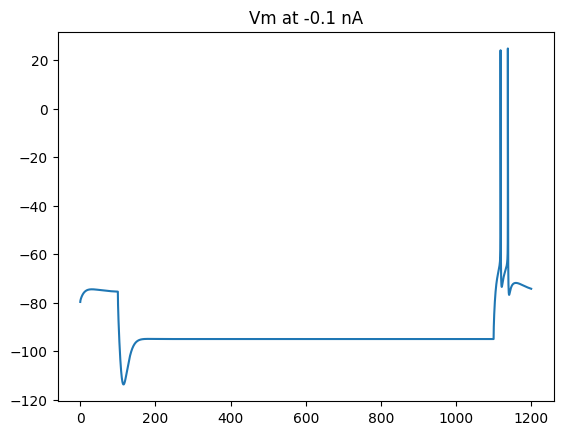

spike frequency = 0.00 Hz


In [21]:
#modify simulation parameters if needed
sim_params['stim_amp'] = -0.1

#rebuild the cell to make sure the set_simulation() is using the correct hobj
#if using hoc call with the hoc filename and cell name

soma_diam_multiplier = 1
hobject = build_cell(soma_diam_multiplier)
#hobject = build_cell(soma_diam_multiplier,using_hoc=True,'HYPO_TEMPLATE.hoc','HYPO')

# run the simulation
h, stim = set_simulation(hobject,sim_params)
v = h.Vector().record(hobject.soma[0](0.5)._ref_v)
h.finitialize()
h.run()

#plot the result and display spike frequency
V = v.as_numpy()
T = np.arange(0,h.tstop+h.dt,h.dt)
plt.plot(T,V)
plt.title(f"Vm at {sim_params['stim_amp']} nA")
plt.show()

print(f"spike frequency = {get_frequency(v,sim_params):.2f} Hz")

In [22]:
#find Rin, tau, sag ratio, and Vrest

print(ACTPassiveModule.compute_gpp(v.as_numpy(), h.dt, sim_params['stim_delay'], h.tstop, sim_params['stim_amp']))
print(f"V-rest: {v.as_numpy()[sim_params['stim_dur']]}")

GettablePassiveProperties(R_in=382.62598661561, tau1=5.25, tau2=985.6, sag_ratio=1.0312181869533368, V_rest=-75.41441453736219)
V-rest: -74.5088917566259


## FI-Curve

In [23]:
#test the cell at multiple frequencies to get an FI curve

frequenies = []
amps = [-0.1, -0.05, 0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]


for amp in amps:
  #if using hoc call with the hoc filename and cell name
    hobject = build_cell(soma_diam_multiplier)
    #hobject = build_cell(soma_diam_multiplier,using_hoc=True,'HYPO_TEMPLATE.hoc','HYPO')

    sim_params['stim_amp'] = amp
    h, stim = set_simulation(hobject,sim_params)
    v = h.Vector().record(hobject.soma[0](0.5)._ref_v)
    h.finitialize()
    h.run()
    frequenies.append(get_frequency(v,sim_params))


In [24]:
for a, f in zip(amps, frequenies):
    print(f"{a}: {f}")

-0.1: 0
-0.05: 0
0: 0
0.05: 90.0
0.1: 141.0
0.15: 179.0
0.2: 3.0
0.25: 2.0
0.3: 2.0


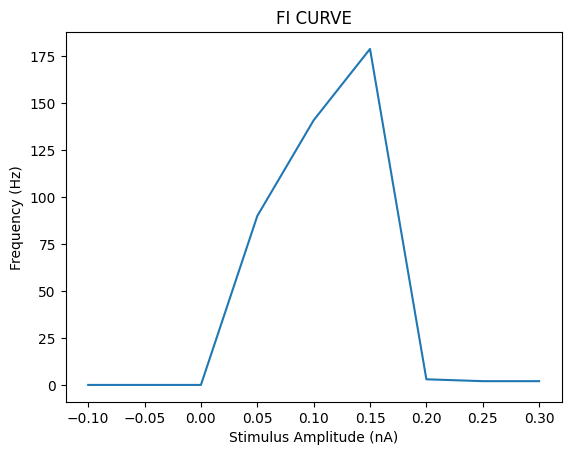

In [25]:

plt.plot(amps, frequenies)
plt.title("FI CURVE")
plt.xlabel("Stimulus Amplitude (nA)")
plt.ylabel("Frequency (Hz)")
plt.show()

# Find prox and dist synapse sites

In [27]:
proximal_region = [20, 60]#um
distal_region = [160,200]

In [28]:
hobject = build_cell(soma_diam_multiplier)

In [232]:
h.distance(0, 0.5, sec=hobject.soma[0])
obj = hobject.dend[32]
dist = h.distance(obj(0.5))

print(f"{dist:.2f} µm")
print(obj.L)
print(hobject.dend[45].nseg)

54.07 µm
87.90002742687342
5


In [28]:
# find the first segment in a branch that is in the prox range, then do the same for distal
#dict key is the sec name, the fields are the segment location, the distance from the soma to that seg, and the length of the section
h.distance(0, 0.5, sec=hobject.soma[0])

proximal_dict = {}
distal_dict = {}

for child_sec in hobject.soma[0].children():
    key = 0
    for sec in child_sec.subtree():
        for seg in sec:
          #because h.distance() returns distance to the section not the segment, and we
          #assume identical lengths for the segments, to location of the segment's
          #proximal end is h.distance + numseg * seglength

            dist = h.distance(sec(0)) + seg.x * sec.L

            data = {
                "root" :child_sec.name(),
                "sec": sec.name(),
                "seg": round(seg.x,2),
                "dist": round(dist,2),
                "L": round(sec.L,2)
                }

            key += 1

            if proximal_region[0] <= dist <= proximal_region[1]:

               proximal_dict[key]  = data


            if distal_region[0] <= dist <= distal_region[1]:

                distal_dict[key] = data



In [29]:
for key in proximal_dict:
  print(proximal_dict[key])

{'root': 'dend[0]', 'sec': 'dend[2]', 'seg': 0.5, 'dist': 38.23, 'L': 17.69}
{'root': 'dend[5]', 'sec': 'dend[5]', 'seg': 0.83, 'dist': 45.66, 'L': 54.79}
{'root': 'dend[0]', 'sec': 'dend[3]', 'seg': 0.17, 'dist': 57.75, 'L': 64.08}
{'root': 'dend[40]', 'sec': 'dend[49]', 'seg': 0.5, 'dist': 47.76, 'L': 28.88}
{'root': 'dend[9]', 'sec': 'dend[14]', 'seg': 0.1, 'dist': 39.75, 'L': 83.47}
{'root': 'dend[40]', 'sec': 'dend[42]', 'seg': 0.5, 'dist': 30.34, 'L': 9.75}
{'root': 'dend[27]', 'sec': 'dend[36]', 'seg': 0.1, 'dist': 38.23, 'L': 82.77}
{'root': 'dend[27]', 'sec': 'dend[36]', 'seg': 0.3, 'dist': 54.79, 'L': 82.77}
{'root': 'dend[9]', 'sec': 'dend[14]', 'seg': 0.3, 'dist': 56.44, 'L': 83.47}
{'root': 'dend[27]', 'sec': 'dend[32]', 'seg': 0.5, 'dist': 54.07, 'L': 87.9}
{'root': 'dend[27]', 'sec': 'dend[30]', 'seg': 0.5, 'dist': 39.63, 'L': 34.3}
{'root': 'dend[27]', 'sec': 'dend[29]', 'seg': 0.1, 'dist': 33.8, 'L': 113.12}
{'root': 'dend[27]', 'sec': 'dend[29]', 'seg': 0.3, 'dist': 5

In [30]:
for key in distal_dict:
  print(distal_dict[key])

{'root': 'dend[40]', 'sec': 'dend[45]', 'seg': 0.7, 'dist': 164.95, 'L': 84.01}
{'root': 'dend[27]', 'sec': 'dend[33]', 'seg': 0.64, 'dist': 177.19, 'L': 123.16}
{'root': 'dend[27]', 'sec': 'dend[33]', 'seg': 0.79, 'dist': 194.79, 'L': 123.16}
{'root': 'dend[22]', 'sec': 'dend[23]', 'seg': 0.9, 'dist': 169.64, 'L': 80.26}
{'root': 'dend[9]', 'sec': 'dend[21]', 'seg': 0.83, 'dist': 166.56, 'L': 59.56}
{'root': 'dend[9]', 'sec': 'dend[15]', 'seg': 0.83, 'dist': 175.86, 'L': 73.18}


In [264]:
# use 32 and 33 for proximal and distal

In [31]:
common = []

for key in proximal_dict:
  root = proximal_dict[key]['root']
  for item in distal_dict:
    if distal_dict[item]['root'] == root:
      common.append(root)

common = list(set(common))


In [32]:
print(f"roots of the dendrites that cover both the proximal and distal regions:\n\t {common}")

roots of the dendrites that cover both the proximal and distal regions:
	 ['dend[27]', 'dend[40]', 'dend[9]']


In [33]:
key = 0
print("proximal")

commonproxdict = {}
for key in proximal_dict:
  if proximal_dict[key]['root'] == common[0]:
    print(proximal_dict[key])
    commonproxdict.update({key:proximal_dict[key]})

    # print(f"{proximal_dict[key]['sec']}({proximal_dict[key]['seg']})")

print("distal:")
commondistaldict = {}
for key in distal_dict:
  if distal_dict[key]['root'] == common[0]:
    print(distal_dict[key])
    commondistaldict.update({key:distal_dict[key]})


proximal
{'root': 'dend[27]', 'sec': 'dend[36]', 'seg': 0.1, 'dist': 38.23, 'L': 82.77}
{'root': 'dend[27]', 'sec': 'dend[36]', 'seg': 0.3, 'dist': 54.79, 'L': 82.77}
{'root': 'dend[27]', 'sec': 'dend[32]', 'seg': 0.5, 'dist': 54.07, 'L': 87.9}
{'root': 'dend[27]', 'sec': 'dend[30]', 'seg': 0.5, 'dist': 39.63, 'L': 34.3}
{'root': 'dend[27]', 'sec': 'dend[29]', 'seg': 0.1, 'dist': 33.8, 'L': 113.12}
{'root': 'dend[27]', 'sec': 'dend[29]', 'seg': 0.3, 'dist': 56.42, 'L': 113.12}
distal:
{'root': 'dend[27]', 'sec': 'dend[33]', 'seg': 0.64, 'dist': 177.19, 'L': 123.16}
{'root': 'dend[27]', 'sec': 'dend[33]', 'seg': 0.79, 'dist': 194.79, 'L': 123.16}


In [ ]:
#SST
#proximal
#according to the linear density plot in figure 3 I
# 2 syns / um


#distal
#

3

In [55]:
# h.distance(0, 0.5, sec=hobject.soma[0])
# for child in hobject.soma[0].children():
#   for child_sec in child.subtree():
#     print(f"child = {child}, {h.distance(child_sec(0))}")

In [254]:
# h.topology()

Test add synapses

In [9]:
from neuron import h
h.load_file("stdrun.hoc")  # Required to use h.run()

1.0

In [10]:
def run(h):

  nmda = h.CPGLUIN(0.5,h.dend[32])
  vecstim = h.VecStim()
  times = h.Vector([500])
  vecstim.play(times)
  rec_times = h.Vector()
  nc = h.NetCon(vecstim, None)  # No target, just record events
  nc.record(rec_times)
  nmdaNetCON = h.NetCon(vecstim,nmda)
  nmdaNetCON.weight[0] = 0.0001

  v = h.Vector().record(h.dend[32](0.5)._ref_v)
  i  = h.Vector().record(nmda._ref_iglu)
  h.finitialize()
  h.dt=0.025
  h.tstop = 1000
  h.run()
  return v,rec_times,times,i

In [11]:
h = build_cell(1)#redifine/add ? to h so as to avoid run() conflict?
v,nc,times,i = run(h)

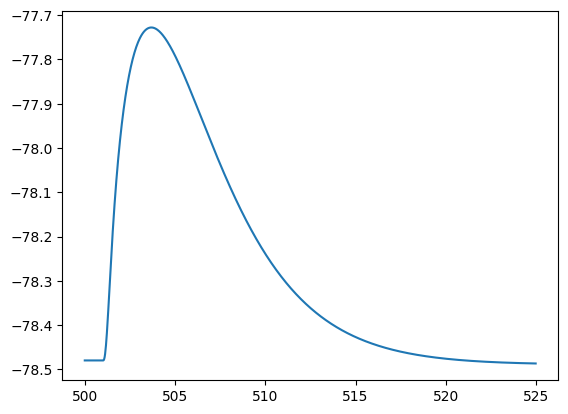

In [12]:
start, end = 20000,21000

V = v.as_numpy()
times = np.arange(0,1000.025,0.025)
plt.plot(times[start:end],V[start:end])

#Add synapses

add single synapse first

In [11]:
from neuron import h
h.load_file("stdrun.hoc")

1.0

In [12]:
nsyn_exc = int(40 *.04 * 2) #syns in the 40 um windows


# h.CPGLUIN(x, sec=cell.SEGMENTS['NEURON_section'][syn]))
def run_sim(h):


  def create_syns(syn_point_proc, seg,dend_sec_no, nsyn):
    syns =  [syn_point_proc(seg, sec=h.dend[int(dend_sec_no)]) for i in range(nsyn)]
    return syns

  #             proximal                                          #distal
  ampa_syns = create_syns(h.CPGLUIN,0.5,32,nsyn_exc) + create_syns(h.CPGLUIN,0.64,33,nsyn_exc)
  nmda_syns =  create_syns(h.NMDAIN,0.5,32,nsyn_exc) + create_syns(h.NMDAIN,0.64,33,nsyn_exc)
  # GABAS = create_syns(h.GABAain,0.5,32,1) + create_syns(h.GABAain,0.64,33,1)


  AMPAS = []
  NMDAS = []
  vecstims_ampa = []
  vecstims_nmda = []

  for i in range(len(ampa_syns)):#assuming same no. ampa and nmda

    vecstims_ampa.append(h.VecStim())
    ampaNetCON = h.NetCon(vecstims_ampa[-1],ampa_syns[i])
    AMPAS.append(ampaNetCON)


    vecstims_nmda.append(h.VecStim())
    nmdaNetCON = h.NetCon(vecstims_nmda[-1],nmda_syns[i])
    NMDAS.append(nmdaNetCON)



  event_times = [[100], [100.5],[101]]
  # vecstims_ampa[0].play(h.Vector([10]))
  vecstims_nmda[0].play(h.Vector(event_times[0]))
  vecstims_ampa[1].play(h.Vector(event_times[1]))
  vecstims_nmda[1].play(h.Vector(event_times[1]))
  v = h.Vector().record(h.dend[32](0.5)._ref_v)


  h.dt=0.025
  h.tstop = 1000
  h.finitialize(-75)
  h.run()
  #clear NEURON level variables so this cell can be rerun
  V = v.as_numpy()

  return V


In [ ]:
h = build_cell(1)
v = run_sim(h)
plt.plot(np.array(v))

In [28]:
# for sec in hobject.allsec():
#     print(f"Section: {sec.name()}")
#     psec = sec.psection()
#     [print(name) for name in psec['point_processes']]

# Build STIMS

quasi-synchronous input used to make Fig 4B 3 (no GABA)

quasi-synchronous means syn1 is activated, then syn2 is activated 0.5ms after, and so on. they tested up to ten synapses

In [34]:
#prox


1.0

play stims

In [ ]:
# sim_params['stim_amp'] = -0.1

#rebuild the cell to make sure the set_simulation() is using the correct hobj
#if using hoc call with the hoc filename and cell name

# soma_diam_multiplier = 1
# hobject = build_cell(soma_diam_multiplier)
#hobject = build_cell(soma_diam_multiplier,using_hoc=True,'HYPO_TEMPLATE.hoc','HYPO')

# run the simulation
# h, stim = set_simulation(hobject,sim_params)


v = h.Vector().record(hobject.soma[0](0.5)._ref_v)
h.dt=0.2
h.finitialize(-51)
h.continuerun(1000)
#plot the result and display spike frequency
V = v.as_numpy()
T = np.arange(0,h.tstop+h.dt,h.dt)
plt.plot(V)
plt.title(f"Vm at {sim_params['stim_amp']} nA")
plt.show()

print(f"spike frequency = {get_frequency(v,sim_params):.2f} Hz")

In [38]:
def PoissonSpikeTrain(freq,
                      dt=None,
                      tstop=1.,
                      seed=None):
    """
    Poisson spike train from a given frequency (homogeneous process)

    """
    if seed is None:
        seed = np.random.randint(1000)
    np.random.seed(seed)

    if dt is not None and (type(freq) in [np.ndarray, np.array, list]):
        spikes = []
        rdms = np.random.uniform(0, 1, size=len(freq))
        for i, rdm in enumerate(rdms):
            if rdm<(freq[i]*dt):
                spikes.append(i*dt)
        return spikes

    elif type(freq) in [float]:
        spikes = np.cumsum(\
                np.random.exponential(1./freq, int(2.*tstop*freq)+10))
        return spikes[spikes<tstop]

    else:
        print('\n missing input --> no spikes generated ! \n')

In [41]:
PoissonSpikeTrain(3.0)

array([0.02665435, 0.2512418 , 0.25752813, 0.89376126, 0.90724566])

In [26]:

# ampaNETCON = h.NetCon(h.VecStim(),syn)

In [ ]:
VECSTIMS[i].play(STIMS[-1])

In [ ]:
# To test this, we 267 generated input patterns by randomly picking a sparse subset of synapses (4%, see Fig. S9) located 268 on a distal (160-200 μm) and proximal (20-60 μm) segment of a single dendritic branch (Fig. 4A) 269 and simulated the arrival of spatially clustered synaptic inputs that are known to engage sublinear 270 integration. This resulted in a small number of synapses (from 2 to 8) that we activated 271 independently and quasi-synchronously (0.5ms delay) to compute the “linear” and “observed” 272 responses in each of the segments (Fig. 4B).

In [ ]:
# -- synaptic activity
    TRAINS = [[] for s in range(len(synapses)*STP_model['Nmax'])]
    for i, syn in enumerate(synapses):
        if excitatory[i]:
            # we draw one spike train:
            train_s = np.array(PoissonSpikeTrain(Stim,
                                    dt=1e-3*dt, tstop=1e-3*tstop,
                                    seed=trialSeed+1000+i)) # Hz,s
            # STP only in excitatory
            N = STP_release_filter(train_s,
                                   seed=trialSeed+2000+i,
                                   **STP_model)
            for n in range(1, STP_model['Nmax']+1):
                # we split according to release number ++ train to ** ms **
                TRAINS[i+len(synapses)*(n-1)] += list(1e3*train_s[N==n])
        else:
            # GABA -> only single release
            # train_s = np.array(PoissonSpikeTrain(bgFreqInhFactor*Stim, # REMOVED
            train_s = np.array(PoissonSpikeTrain(Stim,
                                    dt=1e-3*dt, tstop=1e-3*tstop,
                                    seed=trialSeed+3000+i)) # Hz,s
            TRAINS[i] += list(1e3*train_s) # to ** ms **

    # -- reordering spike trains
    for i in range(len(TRAINS)):
        TRAINS[i] = np.sort(TRAINS[i])

    # -- link events to synapses
    for i in range(len(TRAINS)):
        STIMS.append(h.Vector(TRAINS[i]))
        VECSTIMS[i].play(STIMS[-1])

In [ ]:
def add_synaptic_input(cell, synapses,
                       with_NMDA=False,
                       Nmax_release = 1,
                       boost_AMPA_for_SST_noNMDA=True,
                       Inh_fraction=20./100.,
                       seed=None):
    """
    add AMPA, NMDA and GABA synapses to a given cell

    if Nmax>1
    it adds other synapses with double (Nmax>=2), triple (Nmax>=3), ...
        vesicular synaptic release only on AMPA and NMDA !

    """
    if seed is None:
        seed = np.random.randint(1000)
    np.random.seed(seed)

    AMPAS, NMDAS, GABAS = [], [], []
    ampaNETCONS, nmdaNETCONS, gabaNETCONS = [], [], []
    STIMS, VECSTIMS = [], []

    excitatory = np.random.choice([True, False],
                                  len(synapses),
                                  p=[1.-Inh_fraction, Inh_fraction])

    for nVesicles in range(1, Nmax_release+1):

        for i, syn in enumerate(synapses):

            VECSTIMS.append(h.VecStim())

            # need to avoid x=0 and x=1, to allow ion concentrations variations in NEURON
            x = np.clip(cell.SEGMENTS['NEURON_segment'][syn],
                    1, cell.SEGMENTS['NEURON_section'][syn].nseg-2)\
                            /cell.SEGMENTS['NEURON_section'][syn].nseg

            if excitatory[i]:
                # excitatory synapses

                AMPAS.append(\
                        h.CPGLUIN(x, sec=cell.SEGMENTS['NEURON_section'][syn]))

                if with_NMDA:
                    NMDAS.append(\
                            h.NMDAIN(x, sec=cell.SEGMENTS['NEURON_section'][syn]))

                ampaNETCONS.append(h.NetCon(VECSTIMS[-1], AMPAS[-1]))
                if (cell.params_key=='MC') and (not with_NMDA)\
                        and boost_AMPA_for_SST_noNMDA:
                    # boosted ampa weight
                    ampaNETCONS[-1].weight[0] = cell.params['%s_qAMPA'%cell.params_key]*\
                                    cell.params['%s_qAMPAonlyBoost'%cell.params_key]*\
                                    nVesicles
                else:
                    # regular ampa weight
                    ampaNETCONS[-1].weight[0] = cell.params['%s_qAMPA'%cell.params_key]*\
                                                    nVesicles

                if with_NMDA:
                    nmdaNETCONS.append(h.NetCon(VECSTIMS[-1], NMDAS[-1]))
                    nmdaNETCONS[-1].weight[0] = cell.params['%s_NAR'%cell.params_key]*\
                                                    cell.params['%s_qAMPA'%cell.params_key]*\
                                                    nVesicles

                GABAS.append(None)
                gabaNETCONS.append(None)

            elif nVesicles==1:
                # inhibitory synapses

                GABAS.append(\
                        h.GABAain(x, sec=cell.SEGMENTS['NEURON_section'][syn]))

                gabaNETCONS.append(h.NetCon(VECSTIMS[-1], GABAS[-1]))
                gabaNETCONS[-1].weight[0] = cell.params['%s_qGABA'%cell.params_key]

                AMPAS.append(None)
                NMDAS.append(None)
                ampaNETCONS.append(None)
                nmdaNETCONS.append(None)

            else:
                # nothing, no multi-vesicular of GABAergic synapses
                GABAS.append(None)
                gabaNETCONS.append(None)
                AMPAS.append(None)
                NMDAS.append(None)
                ampaNETCONS.append(None)
                nmdaNETCONS.append(None)

    return AMPAS, NMDAS, GABAS,\
            ampaNETCONS, nmdaNETCONS, gabaNETCONS,\
            STIMS, VECSTIMS, excitatory